# 巡回セールスマン問題

$$
\begin{aligned}
\min_x & \sum_{i,j}d_{i,j}x_{i,t} x_{j,(t+1)\mod n}\\
\mathrm{s.t.} &\sum_t x_{i,t}=1, \forall i\\
&\sum_i x_{i,t} = 1,~\forall t\\
&x_{i,t} \in \{0, 1\}
\end{aligned}
$$

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# ランダムに都市を配置して距離行列を計算
def tsp_distance(n: int):
    x = np.random.uniform(0, 1, n)
    y = np.random.uniform(0, 1, n)
    XX, YY = np.meshgrid(x, y)
    distance = np.sqrt((XX - XX.T)**2 + (YY - YY.T)**2)
    return distance, (x, y)

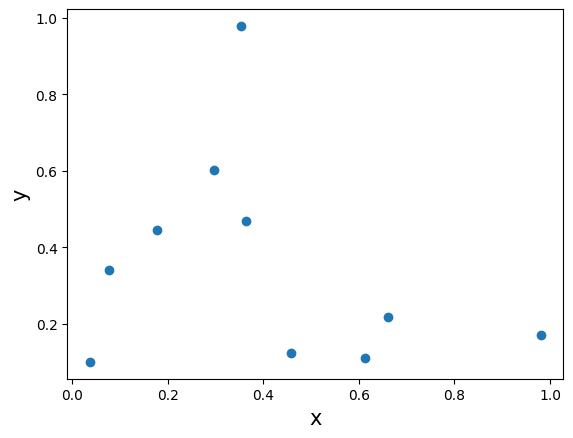

In [8]:
# n-都市 平面TSP
n = 10

distance, (x_pos, y_pos) = tsp_distance(n=n)

plt.plot(x_pos, y_pos, 'o')
plt.xlabel("x", fontsize=15)
plt.ylabel("y", fontsize=15)
plt.show()

## JijModelingによる実装

In [9]:
import jijmodeling as jm

# define variables
d = jm.Placeholder('d', dim=2)
N = d.shape[0].set_latex("N")
x = jm.Binary('x', shape=(N, N))
i = jm.Element('i', (0, N))
j = jm.Element('j', (0, N))
t = jm.Element('t', (0, N))


# set problem
problem = jm.Problem('TSP')
problem += jm.Sum([i, j], d[i, j] * jm.Sum(t, x[i, t]*x[j, (t+1) % N]))
problem += jm.Constraint("one-city", x[:, t] == 1, forall=t)
problem += jm.Constraint("one-time", x[i, :] == 1, forall=i)

problem

In [11]:
instance_data = {
    "d": distance,
}

multipliers = {"one-city": 0.5, "one-time": 0.5}

## JijZeptで解く

In [17]:
import jijzept as jz
import os

# set sampler
sampler = jz.JijSASampler(config=os.environ["JIJZEPT_CONFIG_PATH"])
# solve problem
multipliers = {"one-city": 1.1, "one-time": 1.1}
results = sampler.sample_model(problem, instance_data, multipliers, num_reads=100)

In [18]:
# Show the result of evaluation of solutions
max_show_num = 5
print("Energy: ", results.evaluation.energy[:max_show_num])       # Energy is objective value of QUBO
print("Objective: ", results.evaluation.objective[:max_show_num]) # Objective values of original constrained problem
print("one-city violation: ", results.evaluation.constraint_violations["one-city"][:max_show_num])  # violation of constraints
print("one-time violation: ", results.evaluation.constraint_violations["one-time"][:max_show_num])  # violation of constraints

Energy:  [-18.100587844848633, -17.478118896484375, -17.420778274536133, -17.40070915222168, -17.853092193603516]
Objective:  [3.9899614589265715, 4.62688525439385, 4.685558446543775, 4.706092185433922, 4.243204553423524]
one-city violation:  [0.0, 0.0, 0.0, 0.0, 0.0]
one-time violation:  [0.0, 0.0, 0.0, 0.0, 0.0]


## 実行可能解の抽出

In [19]:
import numpy as np

# Get feasible solution index
onecity_violation = np.array(results.evaluation.constraint_violations["one-city"])
onetime_violation = np.array(results.evaluation.constraint_violations["one-time"])

feasible = [i for i, violation in enumerate(onecity_violation + onetime_violation) if violation == 0]

# Get feasible objective
objective = np.array(results.evaluation.objective)
feas_obj = {i: obj_value for i, obj_value in zip(feasible, objective[feasible])}

lowest_index = min(feas_obj, key=feas_obj.get)

print(f"Lowest solution index: {lowest_index}, Lowest objective value: {feas_obj[lowest_index]}")

Lowest solution index: 32, Lowest objective value: 3.1854883988545435


## 解の確認

In [20]:
nonzero_indices, nonzero_values, shape = results.record.solution["x"][lowest_index]
print("indices: ", nonzero_indices)
print("values: ", nonzero_values)

indices:  ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [2, 1, 0, 6, 9, 5, 3, 4, 8, 7])
values:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


## ツアーの可視化

In [23]:
N_value = len(x_pos)
tour = np.zeros(N_value, dtype=int)

i_value, t_value = nonzero_indices
tour[t_value] = i_value

tour = np.append(tour, [tour[0]])
tour

array([2, 1, 0, 6, 7, 5, 3, 9, 8, 4, 2])

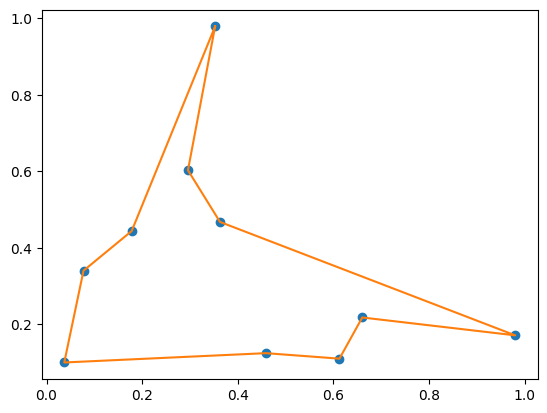

In [28]:
import matplotlib.pyplot as plt

plt.plot(x_pos, y_pos, "o")
plt.plot(x_pos[tour], y_pos[tour], "-")
plt.show()